# Predictor levels within vs. without bounding box

In [123]:
#@title Imports

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import colorsys
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
from sklearn.model_selection import train_test_split

In [124]:
# Load All Images into Dataframe
def load_image(path):
    return_img = None
    try:
        return_img = image.load_img(path)
    except:
        print("Did not find file: " + path)

    return return_img


def get_full_path(name):
    return str("data/trees/" + name)


img_df = pd.read_json("data/img_metadata.json",
                      dtype={'x': float, 'y': float, 'width': float, 'height': float})
img_df["file_name"] = img_df["file_name"].map(get_full_path)


In [125]:
sick_df = img_df[img_df["classification"] == "sick"]
healthy_df = img_df[img_df["classification"] == "healthy"]


In [126]:

avg_rgb_in_bbox = []
avg_rgb_out_bbox = []
avg_rgb_healthy = []

for index, row in sick_df.iterrows():
    file_name = row['file_name']
    x, y, width, height = int(row['x']), int(row['y']), int(row['width']), int(row['height'])
    
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if x != -1 and y != -1 and width != -1 and height != -1:
        region_in_bbox = img[y:y + height, x:x + width]
        avg_rgb_in_bbox.append(np.mean(region_in_bbox, axis=(0, 1)))

        mask = np.ones(img.shape, dtype=bool)
        mask[y:y + height, x:x + width] = False
        region_out_bbox = img[mask].reshape(-1, 3)
        avg_rgb_out_bbox.append(np.mean(region_out_bbox, axis=0))
    else:
        avg_rgb_in_bbox.append(np.array([-1, -1, -1]))
        avg_rgb_out_bbox.append(np.mean(img, axis=(0, 1)))

for index, row in healthy_df.iterrows():
    file_name = row['file_name']
    x, y, width, height = int(row['x']), int(row['y']), int(row['width']), int(row['height'])
    
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    avg_rgb_healthy.append(np.mean(img, axis=(0, 1)))

print(avg_rgb_in_bbox)
print(avg_rgb_out_bbox)
print(avg_rgb_healthy)






[array([55.35197675, 67.71842374, 52.50176898]), array([57.26540557, 65.33123471, 53.64794901]), array([51.83906623, 61.38367672, 46.09191454]), array([43.16024431, 53.01824129, 39.417076  ]), array([58.35754906, 74.32281125, 55.08174919]), array([90.54015991, 92.6184039 , 67.06543086]), array([97.75650536, 99.7032884 , 72.2651018 ]), array([ 95.60399302, 100.75860584,  67.85962459]), array([ 95.92251276, 101.26509169,  68.09480437]), array([ 93.48996973, 101.0254464 ,  66.08288881]), array([105.14507997, 111.03351314,  73.35484431]), array([105.01886936, 110.53154379,  69.31569116]), array([90.70394835, 97.90524705, 61.11341245]), array([ 97.57643678, 102.41922414,  62.59471264]), array([100.57002174, 105.01654348,  65.24063043]), array([107.42679435, 109.08439516,  69.27997984]), array([115.67689759, 119.94225251,  87.16005671]), array([124.28549809, 128.91024634,  96.65549297]), array([128.87843107, 130.3272203 ,  96.15068867]), array([115.95608146, 122.4596527 ,  87.81445781]), arr

In [127]:
rgb_in = pd.DataFrame(avg_rgb_in_bbox)
rgb_out = pd.DataFrame(avg_rgb_out_bbox)
rgb_healthy = pd.DataFrame(avg_rgb_healthy)

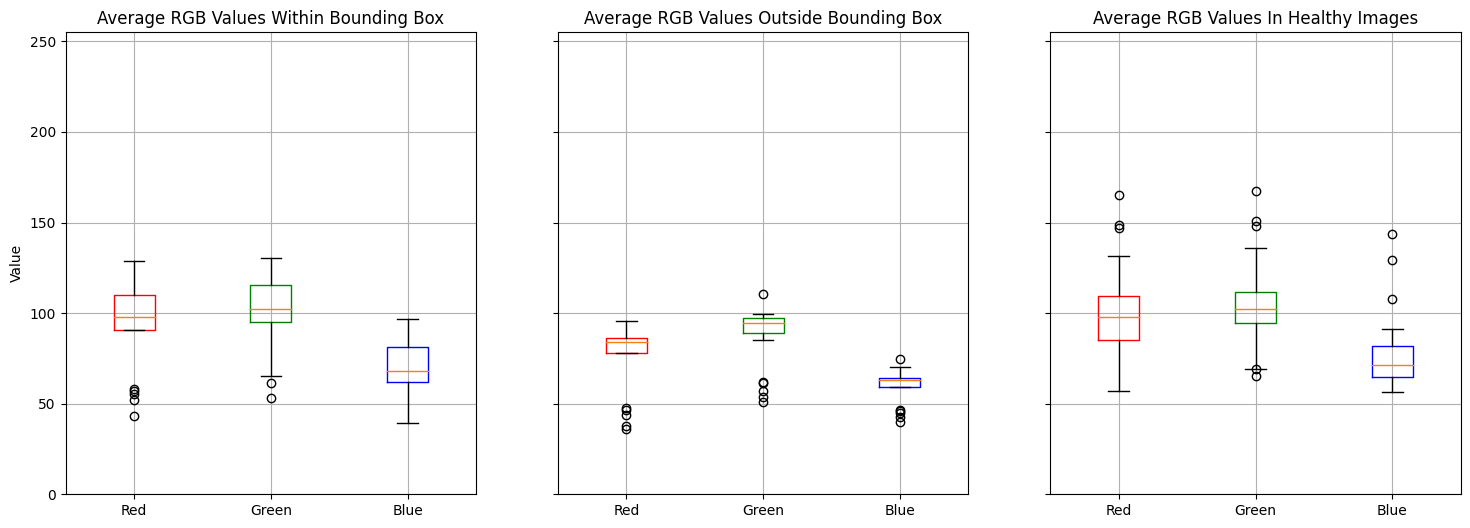

In [137]:
# Create box plots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

colors = ['red', 'green', 'blue']

boxprops = dict(color_vals=colors)

# Box plot for the area within the bounding box
plot1 = ax1.boxplot([rgb_in[0], rgb_in[1], rgb_in[2]],
            labels=['Red', 'Green', 'Blue'])
ax1.set_title('Average RGB Values Within Bounding Box')
ax1.set_ylabel('Value')
ax1.set_ylim([0, 255])
ax1.grid()

# Box plot for the area outside the bounding box
plot2 = ax2.boxplot([rgb_out[0], rgb_out[1], rgb_out[2]],
            labels=['Red', 'Green', 'Blue'])
ax2.set_title('Average RGB Values Outside Bounding Box')
ax2.set_ylim([0, 255])
ax2.grid()

# Box plot for the area outside the bounding box
plot3 = ax3.boxplot([rgb_healthy[0], rgb_healthy[1], rgb_healthy[2]],
            labels=['Red', 'Green', 'Blue'])
ax3.set_title('Average RGB Values In Healthy Images')
ax3.set_ylim([0, 255])
ax3.grid()


for plot in (plot1, plot2, plot3):
    for patch, color in zip(plot['boxes'], colors):
        patch.set_color(color)

# Show the plots

plt.show()

In [138]:
in_red_val_count = np.zeros(256, int)
in_green_val_count = np.zeros(256, int)
in_blue_val_count = np.zeros(256, int)

out_red_val_count = np.zeros(256, int)
out_green_val_count = np.zeros(256, int)
out_blue_val_count = np.zeros(256, int)

healthy_red_val_count = np.zeros(256, int)
healthy_green_val_count = np.zeros(256, int)
healthy_blue_val_count = np.zeros(256, int)


for index, row in sick_df.iterrows():
    file_name = row['file_name']
    x, y, width, height = int(row['x']), int(row['y']), int(row['width']), int(row['height'])
    
    # Read the image using OpenCV
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get the region inside the bounding box
    region_in_bbox = img[y:y + height, x:x + width]
    for img_row in region_in_bbox:
        for px in img_row:
            in_red_val_count[int(px[0])] += 1
            in_green_val_count[int(px[1])] += 1
            in_blue_val_count[int(px[2])] += 1

    # Create a mask to get the region outside the bounding box
    mask = np.ones(img.shape, dtype=bool)
    mask[y:y + height, x:x + width] = False
    region_out_bbox = img[mask].reshape(-1, 3)
    for px in region_out_bbox:
        out_red_val_count[int(px[0])] += 1
        out_green_val_count[int(px[1])] += 1
        out_blue_val_count[int(px[2])] += 1

    print("Evaluated", row['file_name'])


for index, row in healthy_df.iterrows():
    file_name = row['file_name']
    x, y, width, height = int(row['x']), int(row['y']), int(row['width']), int(row['height'])
    
    # Read the image using OpenCV
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for img_row in img:
        for px in img_row:
            healthy_red_val_count[int(px[0])] += 1
            healthy_green_val_count[int(px[1])] += 1
            healthy_blue_val_count[int(px[2])] += 1

    print("Evaluated", row['file_name'])

Evaluated data/trees/DJI_0033.JPG
Evaluated data/trees/DJI_0034.JPG
Evaluated data/trees/DJI_0035.JPG
Evaluated data/trees/DJI_0036.JPG
Evaluated data/trees/DJI_0037.JPG
Evaluated data/trees/DJI_0044.JPG
Evaluated data/trees/DJI_0045.JPG
Evaluated data/trees/DJI_0046.JPG
Evaluated data/trees/DJI_0047.JPG
Evaluated data/trees/DJI_0048.JPG
Evaluated data/trees/DJI_0049.JPG
Evaluated data/trees/DJI_0050.JPG
Evaluated data/trees/DJI_0051.JPG
Evaluated data/trees/DJI_0052.JPG
Evaluated data/trees/DJI_0053.JPG
Evaluated data/trees/DJI_0054.JPG
Evaluated data/trees/DJI_0056.JPG
Evaluated data/trees/DJI_0057.JPG
Evaluated data/trees/DJI_0058.JPG
Evaluated data/trees/DJI_0059.JPG
Evaluated data/trees/DJI_0060.JPG
Evaluated data/trees/DJI_0061.JPG
Evaluated data/trees/DJI_0062.JPG
Evaluated data/trees/DJI_0025.JPG
Evaluated data/trees/DJI_0026.JPG
Evaluated data/trees/DJI_0027.JPG
Evaluated data/trees/DJI_0028.JPG
Evaluated data/trees/DJI_0029.JPG
Evaluated data/trees/DJI_0030.JPG
Evaluated data

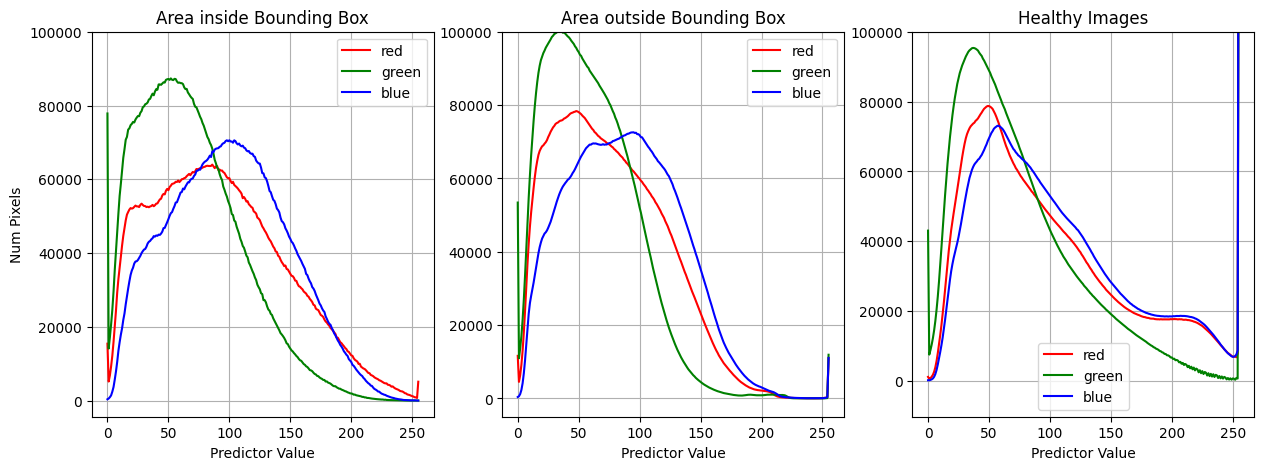

In [141]:
color_vals = range(0,256)

# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first subplot
in_count = sum(in_red_val_count)

ax1.plot(color_vals, in_red_val_count, label='red', color = "red")
ax1.plot(color_vals, in_blue_val_count, label='green', color = "green")
ax1.plot(color_vals, in_green_val_count, label='blue', color = "blue")
ax1.set_ylim(top=100000)
ax1.set_xlabel('Predictor Value')
ax1.set_ylabel('Num Pixels')
ax1.set_title('Area inside Bounding Box')
ax1.legend()
ax1.grid()

# Plot the second subplot
out_count = sum(out_red_val_count)

ax2.plot(color_vals, out_red_val_count * (in_count / out_count), label='red', color = "red")
ax2.plot(color_vals, out_blue_val_count * (in_count / out_count), label='green', color = "green")
ax2.plot(color_vals, out_green_val_count * (in_count / out_count), label='blue', color = "blue")
ax2.set_ylim(top=100000)
ax2.set_xlabel('Predictor Value')
ax2.set_title('Area outside Bounding Box')
ax2.legend()
ax2.grid()

# Plot the healthy subplot
healthy_count = sum(healthy_red_val_count)

ax3.plot(color_vals, healthy_red_val_count * (in_count / healthy_count), label='red', color = "red")
ax3.plot(color_vals, healthy_blue_val_count * (in_count / healthy_count), label='green', color = "green")
ax3.plot(color_vals, healthy_green_val_count * (in_count / healthy_count), label='blue', color = "blue")
ax3.set_ylim(top=100000)
ax3.set_xlabel('Predictor Value')
ax3.set_title('Healthy Images')
ax3.legend()
ax3.grid()

# Display the plot
plt.show()

# Now the same for HSV!!


In [142]:

avg_hsv_in_bbox = []
avg_hsv_out_bbox = []
avg_hsv_healthy = []

for index, row in sick_df.iterrows():
    file_name = row['file_name']
    x, y, width, height = int(row['x']), int(row['y']), int(row['width']), int(row['height'])
    
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    if x != -1 and y != -1 and width != -1 and height != -1:
        region_in_bbox = img[y:y + height, x:x + width]
        avg_hsv_in_bbox.append(np.mean(region_in_bbox, axis=(0, 1)))

        mask = np.ones(img.shape, dtype=bool)
        mask[y:y + height, x:x + width] = False
        region_out_bbox = img[mask].reshape(-1, 3)
        avg_hsv_out_bbox.append(np.mean(region_out_bbox, axis=0))
    else:
        avg_hsv_in_bbox.append(np.array([-1, -1, -1]))
        avg_hsv_out_bbox.append(np.mean(img, axis=(0, 1)))

for index, row in healthy_df.iterrows():
    file_name = row['file_name']
    x, y, width, height = int(row['x']), int(row['y']), int(row['width']), int(row['height'])
    
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    avg_hsv_healthy.append(np.mean(img, axis=(0, 1)))


print(avg_hsv_in_bbox)
print(avg_hsv_out_bbox)
print(avg_hsv_healthy)





[array([64.96893836, 79.33621516, 69.0217327 ]), array([68.85769508, 67.85664234, 67.30285597]), array([54.38983927, 75.53280913, 61.56340423]), array([57.399839  , 78.78229642, 53.17992755]), array([58.95695012, 81.83420253, 74.39266415]), array([34.28265528, 82.22541587, 95.66910247]), array([ 34.342174  ,  83.11643655, 103.55533307]), array([ 37.75569671,  97.28886333, 104.37213337]), array([ 37.73099522,  97.47803939, 105.04124775]), array([ 39.37715322, 104.29934709, 104.06468093]), array([ 36.52569779, 101.83444234, 114.27333419]), array([ 34.94436926, 110.67279684, 113.58940105]), array([ 37.75223914, 110.28168383, 100.05265711]), array([ 35.47313218, 115.09218391, 105.58637931]), array([ 35.10869565, 112.80463043, 108.36845652]), array([ 33.3784879 , 109.02165323, 113.88881048]), array([ 34.8561693 ,  82.50732732, 124.39637562]), array([ 34.38665301,  76.43346419, 133.30956363]), array([ 31.56693937,  79.31697487, 135.27644097]), array([ 35.33954516,  87.41905057, 127.06686757]

In [144]:
hsv_in = pd.DataFrame(avg_hsv_in_bbox)
hsv_out = pd.DataFrame(avg_hsv_out_bbox)
hsv_healthy = pd.DataFrame(avg_hsv_healthy)

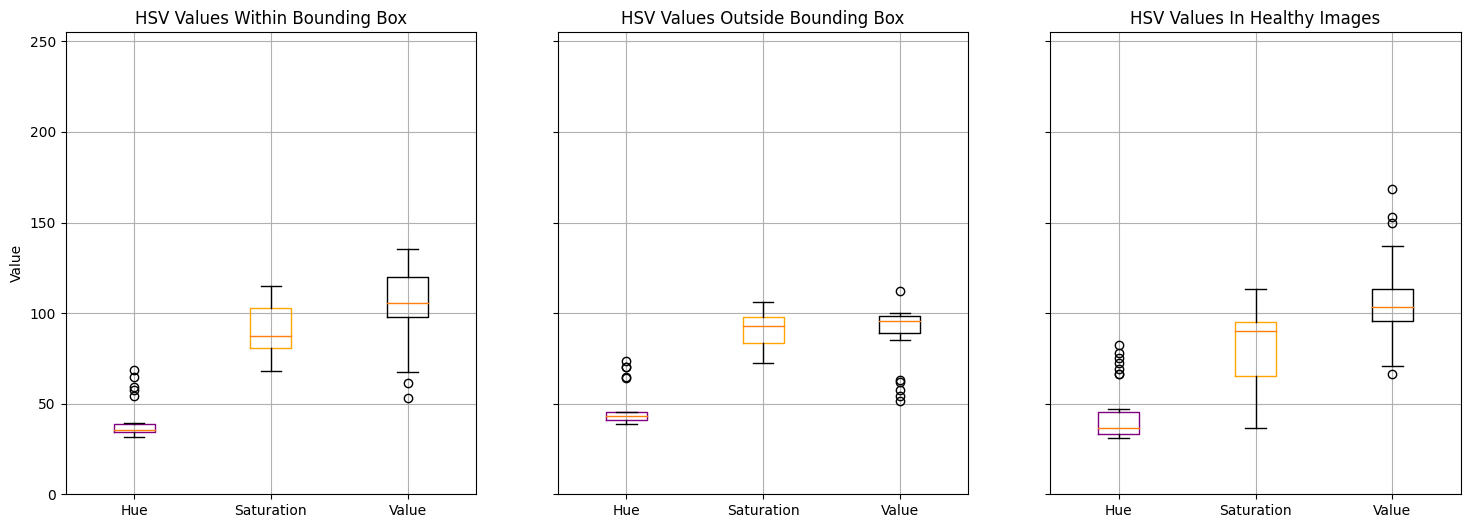

In [145]:
# Create box plots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

hsv_colors = ['purple', 'orange', 'black']

boxprops = dict(color_vals=hsv_colors)

# Box plot for the area within the bounding box
plot1 = ax1.boxplot([hsv_in[0], hsv_in[1], hsv_in[2]],
            labels=['Hue', 'Saturation', 'Value'])
ax1.set_title('HSV Values Within Bounding Box')
ax1.set_ylabel('Value')
ax1.set_ylim([0, 255])
ax1.grid()

# Box plot for the area outside the bounding box
plot2 = ax2.boxplot([hsv_out[0], hsv_out[1], hsv_out[2]],
            labels=['Hue', 'Saturation', 'Value'])
ax2.set_title('HSV Values Outside Bounding Box')
ax2.set_ylim([0, 255])
ax2.grid()

# Box plot for the area outside the bounding box
plot3 = ax3.boxplot([hsv_healthy[0], hsv_healthy[1], hsv_healthy[2]],
            labels=['Hue', 'Saturation', 'Value'])
ax3.set_title('HSV Values In Healthy Images')
ax3.set_ylim([0, 255])
ax3.grid()

for plot in (plot1, plot2, plot3):
    for patch, color in zip(plot['boxes'], hsv_colors):
        patch.set_color(color)

# Show the plots

plt.show()

In [146]:
in_hue_val_count = np.zeros(256, int)
in_sat_val_count = np.zeros(256, int)
in_val_val_count = np.zeros(256, int)

out_hue_val_count = np.zeros(256, int)
out_sat_val_count = np.zeros(256, int)
out_val_val_count = np.zeros(256, int)

healthy_hue_val_count = np.zeros(256, int)
healthy_sat_val_count = np.zeros(256, int)
healthy_val_val_count = np.zeros(256, int)


for index, row in sick_df.iterrows():
    file_name = row['file_name']
    x, y, width, height = int(row['x']), int(row['y']), int(row['width']), int(row['height'])
    
    # Read the image using OpenCV
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Get the region inside the bounding box
    region_in_bbox = img[y:y + height, x:x + width]
    for img_row in region_in_bbox:
        for px in img_row:
            in_hue_val_count[int(px[0])] += 1
            in_sat_val_count[int(px[1])] += 1
            in_val_val_count[int(px[2])] += 1

    # Create a mask to get the region outside the bounding box
    mask = np.ones(img.shape, dtype=bool)
    mask[y:y + height, x:x + width] = False
    region_out_bbox = img[mask].reshape(-1, 3)
    for px in region_out_bbox:
        out_hue_val_count[int(px[0])] += 1
        out_sat_val_count[int(px[1])] += 1
        out_val_val_count[int(px[2])] += 1

    print("Evaluated", row['file_name'])


for index, row in healthy_df.iterrows():
    file_name = row['file_name']
    x, y, width, height = int(row['x']), int(row['y']), int(row['width']), int(row['height'])
    
    # Read the image using OpenCV
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    for img_row in img:
        for px in img_row:
            healthy_hue_val_count[int(px[0])] += 1
            healthy_sat_val_count[int(px[1])] += 1
            healthy_val_val_count[int(px[2])] += 1

    print("Evaluated", row['file_name'])

Evaluated data/trees/DJI_0033.JPG
Evaluated data/trees/DJI_0034.JPG
Evaluated data/trees/DJI_0035.JPG
Evaluated data/trees/DJI_0036.JPG
Evaluated data/trees/DJI_0037.JPG
Evaluated data/trees/DJI_0044.JPG
Evaluated data/trees/DJI_0045.JPG
Evaluated data/trees/DJI_0046.JPG
Evaluated data/trees/DJI_0047.JPG
Evaluated data/trees/DJI_0048.JPG
Evaluated data/trees/DJI_0049.JPG
Evaluated data/trees/DJI_0050.JPG
Evaluated data/trees/DJI_0051.JPG
Evaluated data/trees/DJI_0052.JPG
Evaluated data/trees/DJI_0053.JPG
Evaluated data/trees/DJI_0054.JPG
Evaluated data/trees/DJI_0056.JPG
Evaluated data/trees/DJI_0057.JPG
Evaluated data/trees/DJI_0058.JPG
Evaluated data/trees/DJI_0059.JPG
Evaluated data/trees/DJI_0060.JPG
Evaluated data/trees/DJI_0061.JPG
Evaluated data/trees/DJI_0062.JPG
Evaluated data/trees/DJI_0025.JPG
Evaluated data/trees/DJI_0026.JPG
Evaluated data/trees/DJI_0027.JPG
Evaluated data/trees/DJI_0028.JPG
Evaluated data/trees/DJI_0029.JPG
Evaluated data/trees/DJI_0030.JPG
Evaluated data

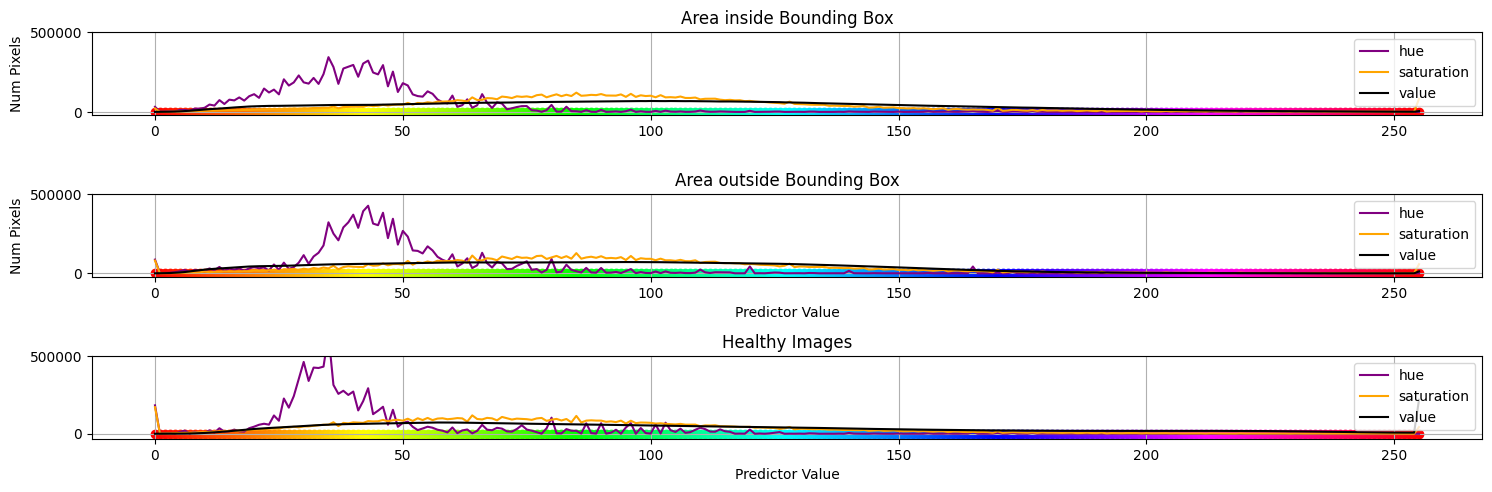

In [149]:
hsv_vals = range(0,256)

# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 5))

# Plot the first subplot
in_count = sum(in_hue_val_count)

ax1.plot(hsv_vals, in_hue_val_count, label='hue', color = "purple")
ax1.plot(hsv_vals, in_sat_val_count, label='saturation', color = "orange")
ax1.plot(hsv_vals, in_val_val_count, label='value', color = "black")
ax1.set_ylim(top=500000)
ax1.set_ylabel('Num Pixels')
ax1.set_title('Area inside Bounding Box')
ax1.legend()
ax1.grid()

for idx, num in enumerate(hsv_vals):
    ax1.scatter(x=idx, y=0, color=colorsys.hsv_to_rgb((idx/255),1,1))

# Plot the second subplot
out_count = sum(out_hue_val_count)

ax2.plot(color_vals, out_hue_val_count * (in_count / out_count), label='hue', color = "purple")
ax2.plot(color_vals, out_sat_val_count * (in_count / out_count), label='saturation', color = "orange")
ax2.plot(color_vals, out_val_val_count * (in_count / out_count), label='value', color = "black")
ax2.set_ylim(top=500000)
ax2.set_xlabel('Predictor Value')
ax2.set_ylabel('Num Pixels')
ax2.set_title('Area outside Bounding Box')
ax2.legend()

ax2.grid()

for idx, num in enumerate(hsv_vals):
    ax2.scatter(x=idx, y=0, color=colorsys.hsv_to_rgb((idx/255),1,1))

# Plot the healthy subplot
healthy_count = sum(healthy_red_val_count)

ax3.plot(color_vals, healthy_hue_val_count * (in_count / healthy_count), label='hue', color = "purple")
ax3.plot(color_vals, healthy_sat_val_count * (in_count / healthy_count), label='saturation', color = "orange")
ax3.plot(color_vals, healthy_val_val_count * (in_count / healthy_count), label='value', color = "black")
ax3.set_ylim(top=500000)
ax3.set_xlabel('Predictor Value')
ax3.set_title('Healthy Images')
ax3.legend()
ax3.grid()

for idx, num in enumerate(hsv_vals):
    ax3.scatter(x=idx, y=0, color=colorsys.hsv_to_rgb((idx/255),1,1))

fig.tight_layout(pad=1)
# Display the plot
plt.show()